<h1 style="font-size:40px"><center>Deep Learning</center></h1>
<h2 style="font-size:25px"><center>Assignment # 5 (Part-2)</center></h2>

### Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<h3 style="font-size:30px"><center>BCEWithLogitsLoss</center></h3>

### Loading Data

In [2]:
# Custom dataset class that includes image paths as well

class ImageFolderWithPaths(datasets.ImageFolder):
    
    #overriding
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        return (original_tuple + (path,))

In [3]:
# Data directory
data_dir = '/mnt/4A34DB4C34DB39A1/Miscellaneous/Data Science Datasets/Corona Dataset/A_05_Part_02_Dataset'


# Defining transformations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Applying transformations on the data
train_data = ImageFolderWithPaths(data_dir + '/Train', transform=train_transforms)
valid_data = ImageFolderWithPaths(data_dir + '/Validation', transform=valid_transforms)
test_data = ImageFolderWithPaths(data_dir + '/Test', transform=test_transforms)


# Data Loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)


print("**** Classes ****")
class_names = tuple(train_data.classes)
print(class_names)

**** Classes ****
('covid-19', 'normal', 'pneumonia')


### Displaying a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


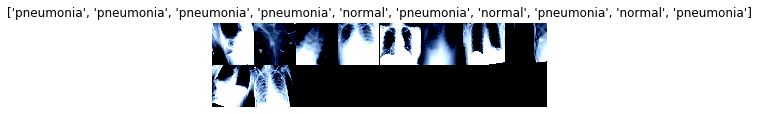

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes, paths = next(iter(trainloader))
show_databatch(inputs, classes)

### Loading pre-trained VGG-16 & ResNet18

In [5]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

### Freezing the layers

In [6]:
for param in vgg16.features.parameters():
    param.require_grad = False
    
for param in resnet18.parameters():
    param.require_grad = False

### Removing last layer + Extending VGG-16 & ResNet18

In [7]:
# Removing last layer of VGG-16
num_features = vgg16.classifier[6].in_features
classifier = list(vgg16.classifier.children())[:-1]
classifier.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*classifier)


# Extending ResNet-18
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, len(class_names)))]))

print('Last layers removed.')

Last layers removed.


### Printing updated Architectures

##### (1) VGG-16

In [8]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###### (2) ResNet-18

In [9]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### BCEWithLogitsLoss  Function & Optimizer

In [10]:
Epochs = 3
criterion = nn.BCEWithLogitsLoss()
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

### Training

##### (1) VGG-16

In [11]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()


vgg16_cross_entropy = []
vgg16_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        vgg16_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        
        # One-Hot encoding labels
        encoder = OneHotEncoder(handle_unknown='ignore')
        labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
        categories = np.array([[0], [1], [2]])
        encoder.fit(categories)
        binary_labels = encoder.transform(labels_in_numpy).toarray()
           
        loss = criterion(outputs, torch.from_numpy(binary_labels).to(device))   #----> compute loss
        loss.backward()                     #----> backward pass
        vgg16_optimizer.step()              #----> weights update
        
        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    vgg16_cross_entropy.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'Saved Models/vgg16_focal_loss.pth')
    
    # Variables for accuracy, precision, recall and F1 score
    correct = 0
    total = 0
    precision = 0
    recall = 0
    f_score = 0
    covid_confusion_matrix = np.zeros((2,2))
    pneu_confusion_matrix = np.zeros((2,2))
    normal_confusion_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoder = OneHotEncoder(handle_unknown='ignore')
            labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
            categories = np.array([[0], [1], [2]])
            encoder.fit(categories)
            binary_labels = encoder.transform(labels_in_numpy).toarray()
            
            # Setting pneumonia to 1 if covid-19 is seen
            for row in range(binary_labels.shape[0]):
                if binary_labels[row][0] == 1:
                    binary_labels[row][2] = 1
                    
            binary_labels = torch.from_numpy(binary_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            binary_labels = torch.Tensor.cpu(binary_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==binary_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(binary_labels, outputs)
            
            # Filling individual confusion matrices
            covid_confusion_matrix[0][0] = covid_confusion_matrix[0][0] + c_matrices[0][0][0]
            covid_confusion_matrix[0][1] = covid_confusion_matrix[0][1] + c_matrices[0][0][1]
            covid_confusion_matrix[1][0] = covid_confusion_matrix[1][0] + c_matrices[0][1][0]
            covid_confusion_matrix[1][1] = covid_confusion_matrix[1][1] + c_matrices[0][1][1]
            
            pneu_confusion_matrix[0][0] = pneu_confusion_matrix[0][0] + c_matrices[1][0][0]
            pneu_confusion_matrix[0][1] = pneu_confusion_matrix[0][1] + c_matrices[1][0][1]
            pneu_confusion_matrix[1][0] = pneu_confusion_matrix[1][0] + c_matrices[1][1][0]
            pneu_confusion_matrix[1][1] = pneu_confusion_matrix[1][1] + c_matrices[1][1][1]
            
            normal_confusion_matrix[0][0] = normal_confusion_matrix[0][0] + c_matrices[2][0][0]
            normal_confusion_matrix[0][1] = normal_confusion_matrix[0][1] + c_matrices[2][0][1]
            normal_confusion_matrix[1][0] = normal_confusion_matrix[1][0] + c_matrices[2][1][0]
            normal_confusion_matrix[1][1] = normal_confusion_matrix[1][1] + c_matrices[2][1][1]
    
    
    vgg16_valid_accuracy.append((100 * correct / total))
    
    
print('VGG-16 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('VGG-16 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(binary_labels, outputs, average='weighted')
print('VGG-16 Precision:', scores[0])
print('VGG-16 Recall:', scores[1])
print('VGG-16 F1 Score:', scores[2])  
    
    
print('\n\n***** Covid-19 Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(covid_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Pneumonia Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(pneu_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Normal Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(normal_confusion_matrix, actual_labels, predicted_labels))

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.495362: : 620it [14:51,  1.44s/it]
Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.038274: : 620it [15:00,  1.45s/it]
Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.140592: : 620it [14:15,  1.38s/it]


VGG-16 Trained!!


****** Scores ******
VGG-16 Accuracy: 89 %
VGG-16 Precision: 0.90625
VGG-16 Recall: 0.875
VGG-16 F1 Score: 0.876984126984127


***** Covid-19 Confusion Matrix *****
              Predicted False  Predicted True
Actual False            598.0             2.0
Actual True              26.0             2.0


***** Pneumonia Confusion Matrix *****
              Predicted False  Predicted True
Actual False            173.0            55.0
Actual True               1.0           399.0


***** Normal Confusion Matrix *****
              Predicted False  Predicted True
Actual False            399.0             1.0
Actual True              58.0           170.0


##### (2) ResNet-18

In [12]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()


resnet18_cross_entropy = []
resnet18_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        # One-Hot encoding labels
        encoder = OneHotEncoder(handle_unknown='ignore')
        labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
        categories = np.array([[0], [1], [2]])
        encoder.fit(categories)
        binary_labels = encoder.transform(labels_in_numpy).toarray()    
        
        loss = criterion(outputs, torch.from_numpy(binary_labels).to(device))   #----> compute loss
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_cross_entropy.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'Saved Models/res18_focal_loss.pth')
    
    # Variables for accuracy, precision, recall and F1 score
    correct = 0
    total = 0
    precision = 0
    recall = 0
    f_score = 0
    covid_confusion_matrix = np.zeros((2,2))
    pneu_confusion_matrix = np.zeros((2,2))
    normal_confusion_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoder = OneHotEncoder(handle_unknown='ignore')
            labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
            categories = np.array([[0], [1], [2]])
            encoder.fit(categories)
            binary_labels = encoder.transform(labels_in_numpy).toarray()
            
            # Setting pneumonia to 1 if covid-19 is seen
            for row in range(binary_labels.shape[0]):
                if binary_labels[row][0] == 1:
                    binary_labels[row][2] = 1
                    
            binary_labels = torch.from_numpy(binary_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            binary_labels = torch.Tensor.cpu(binary_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==binary_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(binary_labels, outputs)
            
            # Filling individual confusion matrices
            covid_confusion_matrix[0][0] = covid_confusion_matrix[0][0] + c_matrices[0][0][0]
            covid_confusion_matrix[0][1] = covid_confusion_matrix[0][1] + c_matrices[0][0][1]
            covid_confusion_matrix[1][0] = covid_confusion_matrix[1][0] + c_matrices[0][1][0]
            covid_confusion_matrix[1][1] = covid_confusion_matrix[1][1] + c_matrices[0][1][1]
            
            pneu_confusion_matrix[0][0] = pneu_confusion_matrix[0][0] + c_matrices[1][0][0]
            pneu_confusion_matrix[0][1] = pneu_confusion_matrix[0][1] + c_matrices[1][0][1]
            pneu_confusion_matrix[1][0] = pneu_confusion_matrix[1][0] + c_matrices[1][1][0]
            pneu_confusion_matrix[1][1] = pneu_confusion_matrix[1][1] + c_matrices[1][1][1]
            
            normal_confusion_matrix[0][0] = normal_confusion_matrix[0][0] + c_matrices[2][0][0]
            normal_confusion_matrix[0][1] = normal_confusion_matrix[0][1] + c_matrices[2][0][1]
            normal_confusion_matrix[1][0] = normal_confusion_matrix[1][0] + c_matrices[2][1][0]
            normal_confusion_matrix[1][1] = normal_confusion_matrix[1][1] + c_matrices[2][1][1]
    
    
    resnet18_valid_accuracy.append((100 * correct / total))
    
    
print('ResNet-18 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('ResNet-18 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(binary_labels, outputs, average='weighted')
print('ResNet-18 Precision:', scores[0])
print('ResNet-18 Recall:', scores[1])
print('ResNet-18 F1 Score:', scores[2])  
    
    
print('\n\n***** Covid-19 Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(covid_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Pneumonia Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(pneu_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Normal Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(normal_confusion_matrix, actual_labels, predicted_labels))

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.503264: : 620it [04:50,  2.14it/s]
Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.211963: : 620it [04:29,  2.30it/s]
Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.267539: : 620it [04:39,  2.22it/s]


ResNet-18 Trained!!


****** Scores ******
ResNet-18 Accuracy: 88 %
ResNet-18 Precision: 0.8958333333333334
ResNet-18 Recall: 0.875
ResNet-18 F1 Score: 0.8681818181818182


***** Covid-19 Confusion Matrix *****
              Predicted False  Predicted True
Actual False            599.0             1.0
Actual True              26.0             2.0


***** Pneumonia Confusion Matrix *****
              Predicted False  Predicted True
Actual False            171.0            57.0
Actual True               3.0           397.0


***** Normal Confusion Matrix *****
              Predicted False  Predicted True
Actual False            397.0             3.0
Actual True              60.0           168.0


### Plottings

##### (1) VGG-16

*** Validation Accuracy ***


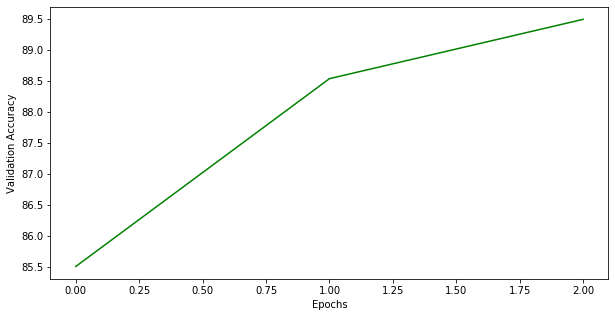

*** Cross Entropy Curve ***


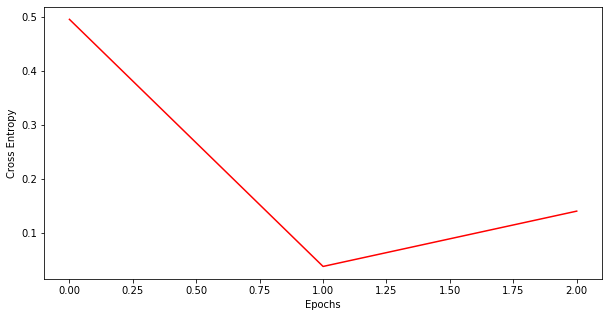

In [13]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

##### (2) ResNet-18

*** Validation Accuracy ***


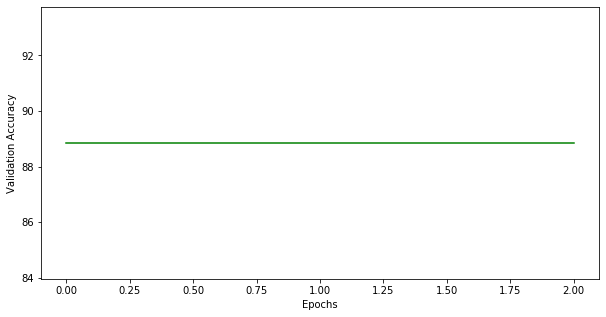

*** Cross Entropy Curve ***


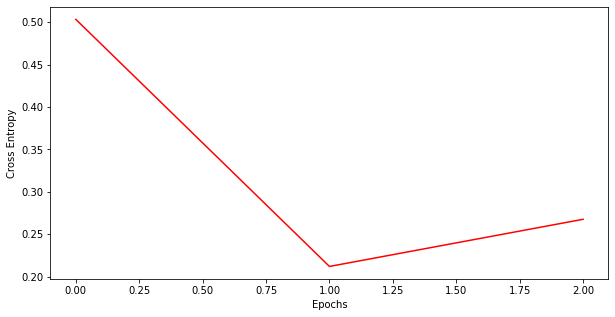

In [14]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

### Testing

##### (1) VGG-16

In [15]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        # if no value is greater than the threshold then defaulting to convert the max value to 1
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)


# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
df.to_csv('MSDS19065_results.csv', index=False, header=False)
print('VGG-16 Test Results Saved in CSV.')

VGG-16 Test Results Saved in CSV.


##### (2) ResNet-18

In [16]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        # if no value is greater than the threshold then defaulting to convert the max value to 1
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)


# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
#df.to_csv('MSDS19065_results.csv', index=False, header=False)
print('ResNet-18 Test Results Saved in CSV.')

ResNet-18 Test Results Saved in CSV.


<h3 style="font-size:30px"><center>Focal Loss</center></h3>

### Loading pre-trained VGG-16 & ResNet18

In [4]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

### Freezing the layers

In [5]:
for param in vgg16.features.parameters():
    param.require_grad = False
    
for param in resnet18.parameters():
    param.require_grad = False

### Removing last layer + Extending VGG-16 & ResNet18

In [6]:
# Removing last layer of VGG-16
num_features = vgg16.classifier[6].in_features
classifier = list(vgg16.classifier.children())[:-1]
classifier.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*classifier)


# Extending ResNet-18
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, len(class_names)))]))

print('Last layers removed.')

Last layers removed.


### Focal Loss & Optimizer

In [7]:
class FocalLoss(torch.nn.Module):
    
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        
    def forward(self, outputs, labels):
        outputs_sigmoid = torch.sigmoid(outputs)
        BCE_loss = F.binary_cross_entropy(outputs_sigmoid, labels, reduce=False)   
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * torch.Tensor.cpu((1-pt)**self.gamma * BCE_loss).detach().numpy()
        return np.mean(F_loss)

In [8]:
Epochs = 3
criterion = FocalLoss(1, 2)
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

### Training

##### (1) VGG-16

In [11]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()


vgg16_cross_entropy = []
vgg16_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        vgg16_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        # One-Hot encoding labels
        encoder = OneHotEncoder(handle_unknown='ignore')
        labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
        categories = np.array([[0], [1], [2]])
        encoder.fit(categories)
        binary_labels = encoder.transform(labels_in_numpy).toarray()
        
        outputs_numpy = torch.Tensor.cpu(outputs).detach().numpy()
        outputs = torch.from_numpy(binary_labels).to(device)
        labels_numpy = torch.Tensor.cpu(torch.from_numpy(binary_labels)).detach().numpy()
         
        loss = criterion(outputs, torch.from_numpy(binary_labels).to(device))   #----> compute loss
        loss = torch.from_numpy(np.asarray(loss)).to(device)
        loss = Variable(loss, requires_grad = True)
        loss.backward()
        vgg16_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss))
        
    vgg16_cross_entropy.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'Saved Models/vgg16_focal_loss.pth')
    
    # Variables for accuracy, precision, recall and F1 score
    correct = 0
    total = 0
    precision = 0
    recall = 0
    f_score = 0
    covid_confusion_matrix = np.zeros((2,2))
    pneu_confusion_matrix = np.zeros((2,2))
    normal_confusion_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoder = OneHotEncoder(handle_unknown='ignore')
            labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
            categories = np.array([[0], [1], [2]])
            encoder.fit(categories)
            binary_labels = encoder.transform(labels_in_numpy).toarray()
            
            # Setting pneumonia to 1 if covid-19 is seen
            for row in range(binary_labels.shape[0]):
                if binary_labels[row][0] == 1:
                    binary_labels[row][2] = 1
                    
            binary_labels = torch.from_numpy(binary_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            binary_labels = torch.Tensor.cpu(binary_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==binary_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(binary_labels, outputs)
            
            # Filling individual confusion matrices
            covid_confusion_matrix[0][0] = covid_confusion_matrix[0][0] + c_matrices[0][0][0]
            covid_confusion_matrix[0][1] = covid_confusion_matrix[0][1] + c_matrices[0][0][1]
            covid_confusion_matrix[1][0] = covid_confusion_matrix[1][0] + c_matrices[0][1][0]
            covid_confusion_matrix[1][1] = covid_confusion_matrix[1][1] + c_matrices[0][1][1]
            
            pneu_confusion_matrix[0][0] = pneu_confusion_matrix[0][0] + c_matrices[1][0][0]
            pneu_confusion_matrix[0][1] = pneu_confusion_matrix[0][1] + c_matrices[1][0][1]
            pneu_confusion_matrix[1][0] = pneu_confusion_matrix[1][0] + c_matrices[1][1][0]
            pneu_confusion_matrix[1][1] = pneu_confusion_matrix[1][1] + c_matrices[1][1][1]
            
            normal_confusion_matrix[0][0] = normal_confusion_matrix[0][0] + c_matrices[2][0][0]
            normal_confusion_matrix[0][1] = normal_confusion_matrix[0][1] + c_matrices[2][0][1]
            normal_confusion_matrix[1][0] = normal_confusion_matrix[1][0] + c_matrices[2][1][0]
            normal_confusion_matrix[1][1] = normal_confusion_matrix[1][1] + c_matrices[2][1][1]
    
    
    vgg16_valid_accuracy.append((100 * correct / total))
    
    
print('VGG-16 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('VGG-16 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(binary_labels, outputs, average='weighted')
print('VGG-16 Precision:', scores[0])
print('VGG-16 Recall:', scores[1])
print('VGG-16 F1 Score:', scores[2])  
    
    
print('\n\n***** Covid-19 Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(covid_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Pneumonia Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(pneu_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Normal Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(normal_confusion_matrix, actual_labels, predicted_labels))

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.123077: : 620it [06:45,  1.53it/s]
Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.123077: : 620it [06:13,  1.66it/s]
Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.123077: : 620it [05:46,  1.79it/s]


VGG-16 Trained!!


****** Scores ******
VGG-16 Accuracy: 24 %
VGG-16 Precision: 0.6875
VGG-16 Recall: 1.0
VGG-16 F1 Score: 0.8095238095238094


***** Covid-19 Confusion Matrix *****
              Predicted False  Predicted True
Actual False            432.0           168.0
Actual True              20.0             8.0


***** Pneumonia Confusion Matrix *****
              Predicted False  Predicted True
Actual False             53.0           175.0
Actual True             103.0           297.0


***** Normal Confusion Matrix *****
              Predicted False  Predicted True
Actual False            195.0           205.0
Actual True             107.0           121.0


##### (2) ResNet-18

In [10]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()


resnet18_cross_entropy = []
resnet18_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
                
        # One-Hot encoding labels
        encoder = OneHotEncoder(handle_unknown='ignore')
        labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
        categories = np.array([[0], [1], [2]])
        encoder.fit(categories)
        binary_labels = encoder.transform(labels_in_numpy).toarray()
        
        outputs_numpy = torch.Tensor.cpu(outputs).detach().numpy()
        outputs = torch.from_numpy(binary_labels).to(device)
        labels_numpy = torch.Tensor.cpu(torch.from_numpy(binary_labels)).detach().numpy()
         
        loss = criterion(outputs, torch.from_numpy(binary_labels).to(device))   #----> compute loss
        loss = torch.from_numpy(np.asarray(loss)).to(device)
        loss = Variable(loss, requires_grad = True)
        
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_cross_entropy.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'Saved Models/res18_focal_loss.pth')
    
    # Variables for accuracy, precision, recall and F1 score
    correct = 0
    total = 0
    precision = 0
    recall = 0
    f_score = 0
    covid_confusion_matrix = np.zeros((2,2))
    pneu_confusion_matrix = np.zeros((2,2))
    normal_confusion_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoder = OneHotEncoder(handle_unknown='ignore')
            labels_in_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
            categories = np.array([[0], [1], [2]])
            encoder.fit(categories)
            binary_labels = encoder.transform(labels_in_numpy).toarray()
            
            # Setting pneumonia to 1 if covid-19 is seen
            for row in range(binary_labels.shape[0]):
                if binary_labels[row][0] == 1:
                    binary_labels[row][2] = 1
                    
            binary_labels = torch.from_numpy(binary_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            binary_labels = torch.Tensor.cpu(binary_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==binary_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(binary_labels, outputs)
            
            # Filling individual confusion matrices
            covid_confusion_matrix[0][0] = covid_confusion_matrix[0][0] + c_matrices[0][0][0]
            covid_confusion_matrix[0][1] = covid_confusion_matrix[0][1] + c_matrices[0][0][1]
            covid_confusion_matrix[1][0] = covid_confusion_matrix[1][0] + c_matrices[0][1][0]
            covid_confusion_matrix[1][1] = covid_confusion_matrix[1][1] + c_matrices[0][1][1]
            
            pneu_confusion_matrix[0][0] = pneu_confusion_matrix[0][0] + c_matrices[1][0][0]
            pneu_confusion_matrix[0][1] = pneu_confusion_matrix[0][1] + c_matrices[1][0][1]
            pneu_confusion_matrix[1][0] = pneu_confusion_matrix[1][0] + c_matrices[1][1][0]
            pneu_confusion_matrix[1][1] = pneu_confusion_matrix[1][1] + c_matrices[1][1][1]
            
            normal_confusion_matrix[0][0] = normal_confusion_matrix[0][0] + c_matrices[2][0][0]
            normal_confusion_matrix[0][1] = normal_confusion_matrix[0][1] + c_matrices[2][0][1]
            normal_confusion_matrix[1][0] = normal_confusion_matrix[1][0] + c_matrices[2][1][0]
            normal_confusion_matrix[1][1] = normal_confusion_matrix[1][1] + c_matrices[2][1][1]
    
    
    resnet18_valid_accuracy.append((100 * correct / total))
    
    
print('ResNet-18 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('ResNet-18 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(binary_labels, outputs, average='weighted')
print('ResNet-18 Precision:', scores[0])
print('ResNet-18 Recall:', scores[1])
print('ResNet-18 F1 Score:', scores[2])  
    
    
print('\n\n***** Covid-19 Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(covid_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Pneumonia Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(pneu_confusion_matrix, actual_labels, predicted_labels))

print('\n\n***** Normal Confusion Matrix *****')
actual_labels = ["Actual False", "Actual True"]
predicted_labels = ["Predicted False", "Predicted True"]
print(pd.DataFrame(normal_confusion_matrix, actual_labels, predicted_labels))

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.123077: : 620it [03:08,  3.28it/s]
Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.123077: : 620it [03:11,  3.23it/s]
Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.123077: : 620it [03:16,  3.15it/s]


ResNet-18 Trained!!


****** Scores ******
ResNet-18 Accuracy: 8 %
ResNet-18 Precision: 0.6458333333333334
ResNet-18 Recall: 0.75
ResNet-18 F1 Score: 0.6931818181818181


***** Covid-19 Confusion Matrix *****
              Predicted False  Predicted True
Actual False             92.0           508.0
Actual True              12.0            16.0


***** Pneumonia Confusion Matrix *****
              Predicted False  Predicted True
Actual False            106.0           122.0
Actual True             118.0           282.0


***** Normal Confusion Matrix *****
              Predicted False  Predicted True
Actual False            289.0           111.0
Actual True             119.0           109.0


### Plotting

##### (1) VGG-16

*** Validation Accuracy ***


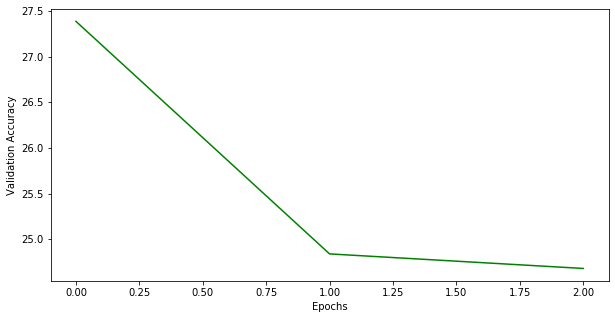

*** Cross Entropy Curve ***


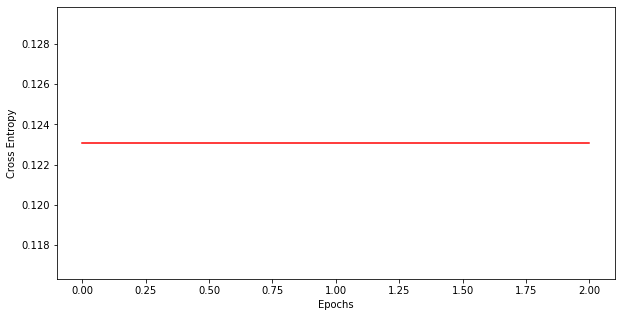

In [12]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

##### (2) ResNet-18

*** Validation Accuracy ***


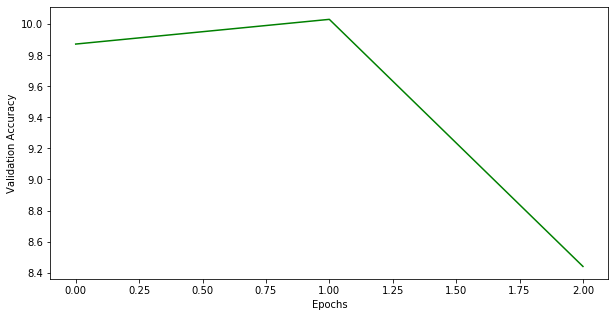

*** Cross Entropy Curve ***


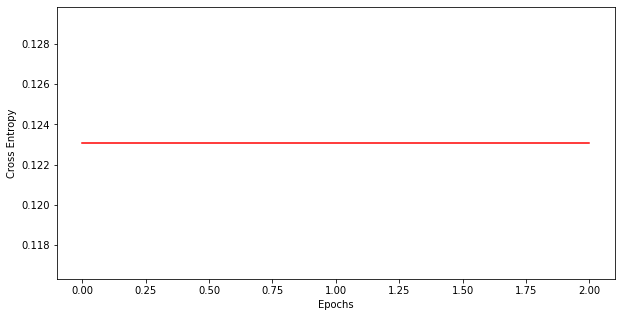

In [13]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

### Testing

##### (1) VGG-16

In [14]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        # if no value is greater than the threshold then defaulting to convert the max value to 1
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)


# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
# df.to_csv('MSDS19065_results.csv', index=False, header=False)
print('VGG-16 Test Results Saved in CSV.')

VGG-16 Test Results Saved in CSV.


##### (2) ResNet-18

In [15]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        # if no value is greater than the threshold then defaulting to convert the max value to 1
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)


# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
# df.to_csv('MSDS19065_results.csv', index=False, header=False)
print('ResNet-18 Test Results Saved in CSV.')

ResNet-18 Test Results Saved in CSV.
